# Data preparation 

Data preparation requires the following steps: 

- Read the annotation file and create json file
- Create Json file in the format required by AutoML for train, validation and test dataset 
- Create AUTOML table for train, validation and test dataset 
- Register data asset in Azure Machine learning 
- Test Azure ML Data Asset 


## Connect to ML Client and Default Datastore 

In [1]:
from lib import get_client
client=get_client()
print(f'workspace name: {client.workspace_name}')
datastore=client.datastores.get_default()
print(f'default datastore : {datastore.name} type: {datastore.type}')

workspace name: azure-ml
default datastore : storecapture type: DatastoreType.AZURE_DATA_LAKE_GEN2


## Create JSON file and MLTABLE

For automl task data set must have the following format:
```json lines
{
   "image_url":"azureml://subscriptions/<my-subscription-id>/resourcegroups/<my-resource-group>/workspaces/<my-workspace>/datastores/<my-datastore>/paths/<path_to_image>",
   "image_details":{
      "format":"image_format",
      "width":"image_width",
      "height":"image_height"
   },
   "label":[
      {
         "label":"class_name_1",
         "topX":"xmin/width",
         "topY":"ymin/height",
         "bottomX":"xmax/width",
         "bottomY":"ymax/height",
         "isCrowd":"isCrowd"
      },
      {
         "label":"class_name_2",
         "topX":"xmin/width",
         "topY":"ymin/height",
         "bottomX":"xmax/width",
         "bottomY":"ymax/height",
         "isCrowd":"isCrowd"
      },
      "..."
   ]
}

```

See: https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema?view=azureml-api-2




Images files are in train and test folders on ``lab-data/fashionpedia`` on the default datastore 

In [2]:
# Root dir of train images in the default dataset 
train_image_root_path = "lab-data/fashionpedia/train"
# Root dir of test and validation images in the default dataset 
test_image_root_path = "lab-data/fashionpedia/test"

Retrieve the azureml path associated with train and test root path 

In [3]:
from lib import build_azure_data_path
azureml_train_images_path = build_azure_data_path(client, datastore, train_image_root_path)
azureml_test_images_path = build_azure_data_path(client, datastore, test_image_root_path)
print(f'azureml train image root path: {azureml_train_images_path}')
print(f'azureml test & validation image root path: {azureml_test_images_path}')

azureml train image root path: azureml://subscriptions/7db1ee9f-abea-4b8b-b5a9-e6e82ecfa19d/resourcegroups/azure-ml/workspaces/azure-ml/datastores/storecapture/paths/lab-data/fashionpedia/train
azureml test & validation image root path: azureml://subscriptions/7db1ee9f-abea-4b8b-b5a9-e6e82ecfa19d/resourcegroups/azure-ml/workspaces/azure-ml/datastores/storecapture/paths/lab-data/fashionpedia/test


Read annotation file and create an Azure automl json line and MLTABLE files for each dataset 

In [4]:
from lib import create_json_object_detection_dataset
import mltable
from mltable import  DataType

def build_automl_table(table_folder:str,json_line_path:str):
    paths = [{'file': json_line_path}]
    tbl=mltable.from_json_lines_files(paths)
    data_types = {
    "image_url": DataType.to_stream()
    }
    tbl=tbl.convert_column_types(data_types)
    mltable_folder = table_folder
    tbl.save(mltable_folder)
    

def build_object_detection_dataset(annotations_url,azure_image_root_path,json_file_location,mtable_folder):
    create_json_object_detection_dataset(annotations_url,json_file_location, azure_image_root_path+"/")
    build_automl_table(mtable_folder, json_file_location)

In [5]:
build_object_detection_dataset(annotations_url="https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json",
                               azure_image_root_path= azureml_train_images_path,
                               json_file_location="data/train/train.jsonl",
                               mtable_folder="data/train")   

loading annotations into memory...
Done (t=137.86s)
write detection dataset...
Conversion completed. Converted 45623 lines.
Done (t=11.88s)


In [6]:
build_object_detection_dataset(annotations_url="https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json",
                               azure_image_root_path= azureml_test_images_path,
                               json_file_location="data/validation/validation.jsonl",
                               mtable_folder="data/validation")    
    

loading annotations into memory...
Done (t=5.18s)
write detection dataset...
Conversion completed. Converted 1158 lines.
Done (t=0.35s)


## Register Data Asset 

We 'll register our data set as azure machine learning data asset. 

In [7]:
asset_prefix_name="-fashionpedia-detection-automl"
asset_prefix_description="data set for fashionpedia object detection"

In [8]:
from lib import get_or_create_table_data_asset
def register_data_asset(scope):
    return get_or_create_table_data_asset(client=client,mltable_folder="data/"+scope,
                                  name=scope+asset_prefix_name,
                                  version="1.0.0",
                                  description=scope+" "+asset_prefix_description)



In [9]:
ds_train=register_data_asset(scope="train")

datastore name: train-fashionpedia-detection-automl version: 1.0.0 not exist create and get it


In [10]:
ds_validation=register_data_asset(scope="validation")

datastore name: validation-fashionpedia-detection-automl version: 1.0.0 not exist create and get it


Uploading validation (1.43 MBs): 100%|██████████| 1434872/1434872 [00:02<00:00, 650725.63it/s]




## Test Data Asset 

Access to the data via the data asset MLTABLE

In [11]:
tbl_validation = mltable.load(f"azureml:/{ds_validation.id}").to_pandas_dataframe()
tbl_validation

,image_url,image_details,label
0,storecapture/lab-data/fashionpedia/test/e14733...,"{'format': 'jpg', 'width': 771, 'height': 1024}","[{'label': 'pocket', 'topX': 0.488975356679636..."
1,storecapture/lab-data/fashionpedia/test/b4f6d9...,"{'format': 'jpg', 'width': 1024, 'height': 680}","[{'label': 'glasses', 'topX': 0.3642578125, 't..."
2,storecapture/lab-data/fashionpedia/test/8075d3...,"{'format': 'jpg', 'width': 1024, 'height': 682}","[{'label': 'top', 'topX': 0.2998046875, 'topY'..."
3,storecapture/lab-data/fashionpedia/test/32e566...,"{'format': 'jpg', 'width': 1024, 'height': 682}","[{'label': 'vest', 'topX': 0.462890625, 'topY'..."
4,storecapture/lab-data/fashionpedia/test/0229be...,"{'format': 'jpg', 'width': 1024, 'height': 768}","[{'label': 'neckline', 'topX': 0.6259765625, '..."
...,...,...,...
1153,storecapture/lab-data/fashionpedia/test/fd567f...,"{'format': 'jpg', 'width': 680, 'height': 1024}","[{'label': 'flower', 'topX': 0.530882352941176..."
1154,storecapture/lab-data/fashionpedia/test/f8ae09...,"{'format': 'jpg', 'width': 880, 'height': 1024}","[{'label': 'shoe', 'topX': 0.5056818181818182,..."
1155,storecapture/lab-data/fashionpedia/test/fdcd32...,"{'format': 'jpg', 'width': 460, 'height': 1024}","[{'label': 'watch', 'topX': 0.7239130434782609..."
1156,storecapture/lab-data/fashionpedia/test/977984...,"{'format': 'jpg', 'width': 681, 'height': 1024}","[{'label': 'dress', 'topX': 0.3274596182085169..."


Check if image paths are correct

In [12]:
from lib import AzureImageReader
from lib import plot_random_images
from azureml.fsspec import AzureMachineLearningFileSystem
# Create an image reader that can read the image on our datastore 
# and return a numpy image. 
datastore_path=build_azure_data_path(client,datastore)
fs=AzureMachineLearningFileSystem(uri=datastore_path)
image_reader=AzureImageReader(fs,output_format='numpy')

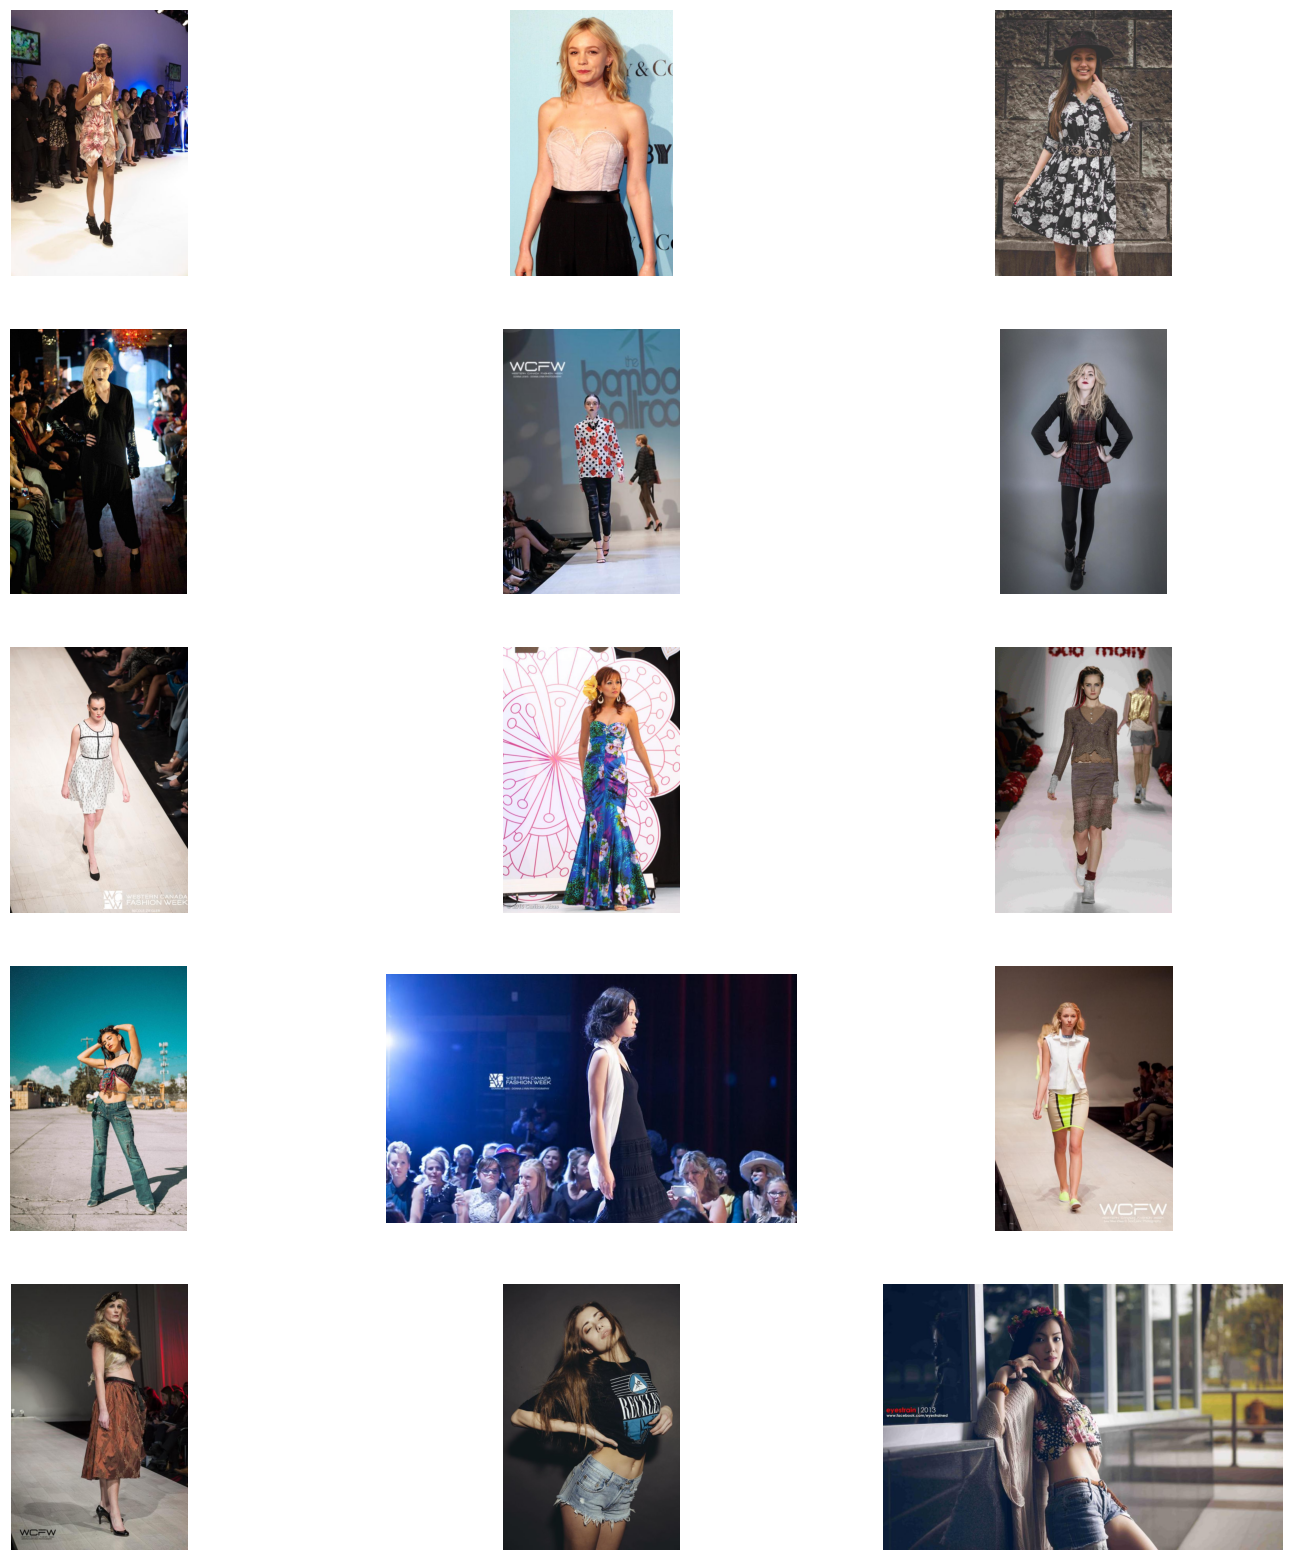

In [13]:
plot_random_images(tbl_validation,image_reader=image_reader)

Check if box annotations have been correctly set

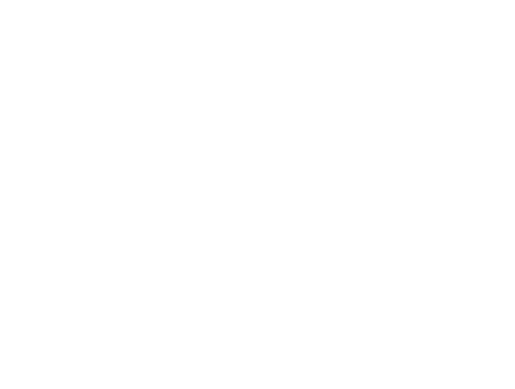

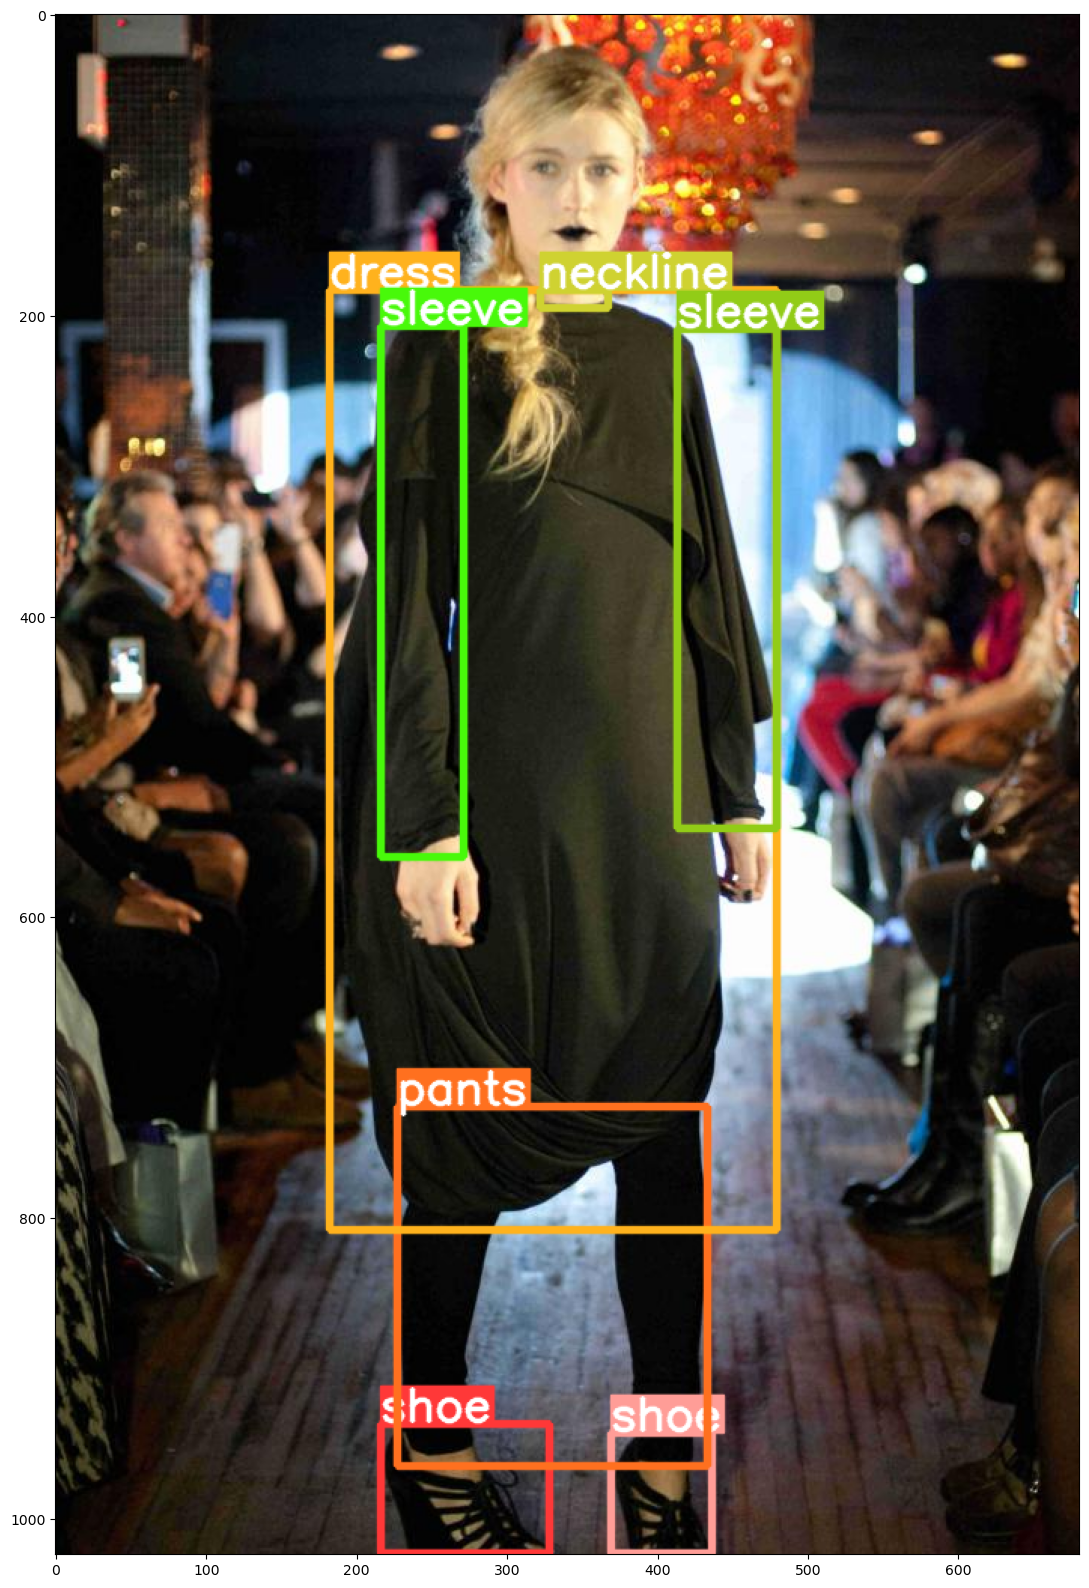

In [14]:
from lib import plot_image_with_boxes
plot_image_with_boxes(tbl_validation,image_reader,786)